In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

import numpy as np
import pandas as pd
from vr2f.eyetracking import et_plot_gaze_saccades, ms_toolbox
from vr2f.staticinfo import COLORS, CONSTANTS, PATHS

paths = PATHS()
colors = COLORS()
constants = CONSTANTS()
cm = constants.CM

In [2]:
# read in the preprocessed data
pattern = "preproc.csv"

sub_list_str_et = [f for f in os.listdir(paths.DATA_ET_PREPROC) if pattern in f]
sub_list_str_et = [f.split("-")[0] for f in sub_list_str_et]
sub_list_str_et = np.unique(sorted(sub_list_str_et))

data_preproc = []
for sub_id in sorted(sub_list_str_et):
    fname = Path(paths.DATA_ET_PREPROC, f"{sub_id}-ET-{pattern}")
    df_clean = pd.read_csv(fname, sep=",")
    df_clean["sub_id"] = sub_id
    data_preproc.append(df_clean)

df_all = pd.concat(data_preproc, ignore_index=True)

You can plot the supplementary figures to visualize the gaze and the detected saccades for specific trials like this: 

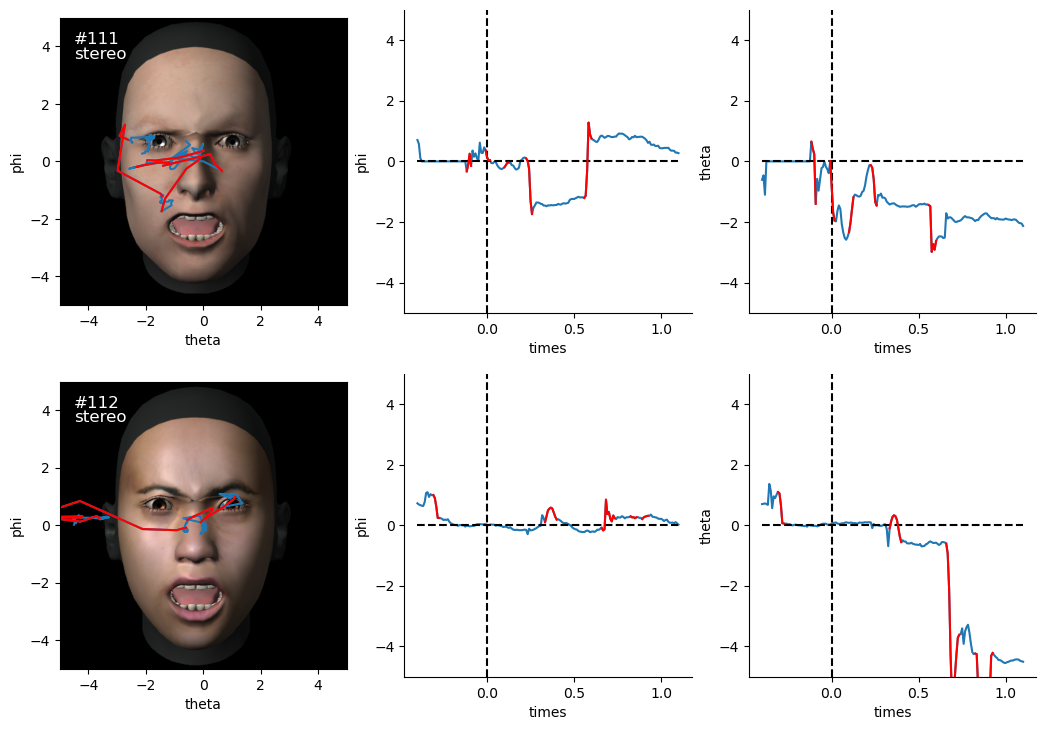

In [62]:

sub_id = "VR2FEM_S01"
trial_range = range(111, 113)
myfig = et_plot_gaze_saccades.plot_gaze_sacc_per_trial(df_all, sub_id, trial_range, sfreq=120)


To render PDFs (`results/figures/ET/Gaze_saccades`) with all trials for a given subject (or all of them), use the bash functionality of `et_plot_gaze_saccades.py` (ideally with the slurm script in `/code/HPC`). 

In [70]:
trial_range = range(1, 745)

sub_id = "VR2FEM_S01"
sfreq = 120
vfac = 5
mindur = 3
min_sac_amp = 1

df_sub = (df_all.
            copy().
            query("sub_id == @sub_id")
)

df_o = pd.DataFrame()
df_gaze = pd.DataFrame()
# trial_range =  trial_range #range(24,745)
for trial_idx in trial_range:
  df_st = et_plot_gaze_saccades.get_data_sub_trialnum(df_sub, sub_id, trial_idx)
  data = df_st.loc[:,["theta", "phi"]].to_numpy()
  sac, rad = ms_toolbox.microsacc(data, srate=sfreq, vfac=vfac, mindur=mindur)
  sac["trial_num"] = trial_idx
  df_o = pd.concat([df_o, sac], ignore_index=True)
  df_st["gaze_state"] = "fix"
  df_st["idx_fix"] = 0
  for i, row in sac.iterrows():
    onset = row["idx_onset"]
    offset = row["idx_offset"]
    # df_st = df_st.drop(["level_0"], axis=1).reset_index()
    df_st.loc[onset:offset+1, ["gaze_state"]] = "sacc"
    df_st.loc[onset:offset+1, ["idx_sacc"]] = i
    df_st.loc[offset:, "idx_fix"] = i+1
  df_gaze = pd.concat([df_gaze, df_st], ignore_index=True)
  df_gaze["idx_sacc"] = df_gaze["idx_sacc"].fillna(-99)
  df_gaze["idx_sacc"] = df_gaze["idx_sacc"].astype(int)


In [89]:

design_df = (df_gaze
              .loc[:, ["sub_id", "trial_num", "emotion", "viewcond", "avatar_id"]]
              .drop_duplicates()
)

fix = pd.DataFrame(columns=["sub_id", "trial_num", "idx_onset", "idx_offset", "duration",
                            "time_onset", "time_offset", "center_theta", "center_phi"])
fixations = (df_gaze
  .query("gaze_state == 'fix'")
  .groupby(["sub_id", "trial_num", "gaze_state", "idx_fix"], as_index=False)
  .agg({"times": ["first", "last"],
        "theta": "mean",
        "phi": "mean"})
  .reset_index()
)
fixations.columns = list(map("".join, fixations.columns))
fixations.columns = (fixations.rename(columns={"timesfirst": "times_onset", "timeslast":
                                              "times_offset", "thetamean": "center_theta", "phimean": "center_phi"})
                              .columns
)
fixations["duration"] = fixations["times_offset"] - fixations["times_onset"]

# fixation must last at least 50ms
fix_mindur = 0.05
baseline = (-0.2, 0.0)
fixations_baseline = (fixations
                        .query("times_onset < @baseline[0] & \
                                times_onset < @baseline[1] & \
                                  duration > @fix_mindur")
                        .merge(design_df, on=["sub_id", "trial_num"])
)

fixations_first = (fixations
                    .query("times_onset > 0 & duration > @fix_mindur")
                    .groupby(["sub_id", "trial_num"], as_index=False)
                    .first()
                    .merge(design_df, on=["sub_id", "trial_num"])
)

tmp_offsets = fixations_first.loc[:,["times_offset", "trial_num"]]

fixations_later = (fixations
                     .merge(tmp_offsets, on=["trial_num"], suffixes=("", "_first"))
                     .query("times_onset > times_offset_first & duration > @fix_mindur")
                     .merge(design_df, on=["sub_id", "trial_num"])
)
res = (fixations_baseline
          .groupby(["emotion"], as_index=False)
          .agg({"times_onset": "mean",
                "duration": "mean",
                 "center_theta": "mean",
                 "center_phi": "mean"})
)
res






,emotion,times_onset,duration,center_theta,center_phi
0,angry,-0.367241,0.382225,-0.044259,0.081903
1,happy,-0.363333,0.394250,0.042219,0.021625
2,neutral,-0.360468,0.395402,0.100011,0.006851
3,surprised,-0.369781,0.430000,0.109674,0.067052


In [84]:
design_df = (df_gaze
              .loc[:, ["sub_id", "trial_num", "emotion", "viewcond", "avatar_id"]]
              .drop_duplicates()
)
design_df

,sub_id,trial_num,emotion,viewcond,avatar_id
0,VR2FEM_S01,1,happy,mono,Woman_04
181,VR2FEM_S01,2,neutral,mono,Woman_01
362,VR2FEM_S01,3,angry,mono,Woman_08
543,VR2FEM_S01,4,happy,mono,Woman_08
724,VR2FEM_S01,5,angry,mono,Woman_04
...,...,...,...,...,...
133759,VR2FEM_S01,740,happy,mono,Woman_04
133940,VR2FEM_S01,741,neutral,mono,Woman_04
134121,VR2FEM_S01,742,surprised,mono,Woman_04
134302,VR2FEM_S01,743,surprised,stereo,Woman_08


In [82]:
df_gaze.columns

Index(['level_0', 'index', 'time', 'timestamp_et', 'timestamp_lsl',
       'direction_x_local', 'direction_y_local', 'direction_z_local',
       'position_x_local', 'position_y_local', 'position_z_local',
       'diameter_right', 'diameter_left', 'theta', 'phi', 'r', 'times',
       'trial_num', 'marker', 'viewcond', 'avatar_id', 'emotion', 'blink',
       'theta_baseline', 'phi_baseline', 'sub_id', 'gaze_state', 'idx_fix',
       'idx_sacc'],
      dtype='object')

In [8]:

times = df_sub["times"]

df_o["time_onset"] = df_o["idx_onset"].map(lambda x: times[x])
df_o["time_offset"] = df_o["idx_offset"].map(lambda x: times[x])
df_o["amp_tot"] = np.sqrt(df_o["amp_x"]**2 + df_o["amp_y"]**2)

df_agg = df_o.groupby(["trial_num"]).agg({"amp_tot": ["count", "mean"],
                                          "amp_x": ["mean"],
                                          "amp_y": ["mean"]}).reset_index()
df_agg.columns = df_agg.columns.droplevel(0)
df_agg.columns = ["trial_num", "n_sac", "mean_sac_amp", "mean_sac_amp_x", "mean_sac_amp_y"]


In [9]:
df_mm = (df_sub
          .groupby(["trial_num"])
          .first()
          .reset_index()
          .merge(df_agg, on=["trial_num"]))
res = (df_mm.
        groupby(["emotion"])
        .agg({"n_sac": ["mean", "std"],
              "mean_sac_amp": ["mean", "std"],
              "mean_sac_amp_x": ["mean", "std"],
              "mean_sac_amp_y": ["mean", "std"]})
)

res

n_sac           mean_sac_amp           mean_sac_amp_x            \
               mean       std         mean       std           mean       std   
emotion                                                                         
angry      6.981481  2.050518     1.496515  0.465966      -0.167587  0.399216   
happy      6.580838  2.405639     1.489986  0.495001      -0.224830  0.428689   
neutral    6.933333  2.422288     1.570467  0.553346      -0.241987  0.503924   
surprised  6.844311  2.541170     1.496896  0.490538      -0.197061  0.527945   

          mean_sac_amp_y            
                    mean       std  
emotion                             
angry           0.075865  0.260362  
happy          -0.003150  0.283130  
neutral         0.001050  0.279607  
surprised       0.014623  0.274336

In [9]:
df_mm

,trial_num,level_0,index,time,timestamp_et,timestamp_lsl,direction_x_local,direction_y_local,direction_z_local,position_x_local,...,marker,viewcond,avatar_id,emotion,blink,theta_baseline,phi_baseline,sub_id,n_sac,mean_sac_amp
0,25,5803,362,707.1563,1453001,5748.020156,0.135437,0.020004,0.990570,0.012213,...,122,mono,Woman_04,happy,False,-0.009306,-0.225854,VR2FEM_S01,11,2.155359
1,26,6044,24,712.6712,1458516,5753.536039,-0.011978,0.006897,0.999893,0.004437,...,224,stereo,Woman_04,surprised,False,-0.723849,-0.993154,VR2FEM_S01,8,2.912147
2,27,6285,22,718.2582,1464098,5759.118334,-0.005951,-0.006454,0.999954,-0.005276,...,131,mono,Woman_08,neutral,False,-1.456091,0.254742,VR2FEM_S01,9,2.126068
3,28,6526,22,723.2939,1469139,5764.159241,0.004395,-0.004196,0.999970,-0.004211,...,211,stereo,Woman_01,neutral,False,0.242540,0.349134,VR2FEM_S01,6,2.260800
4,29,6767,23,728.7231,1474562,5769.583366,-0.000137,-0.009201,0.999954,-0.003327,...,134,mono,Woman_08,surprised,False,-0.133806,0.375978,VR2FEM_S01,8,1.688803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,740,178118,24,6866.1160,3500148,12090.460342,0.003311,-0.010178,0.999939,-0.002157,...,122,mono,Woman_04,happy,False,0.251291,0.567412,VR2FEM_S01,4,1.356082
657,741,178359,23,6870.3610,3504389,12094.701317,-0.003693,-0.008163,0.999954,-0.002255,...,121,mono,Woman_04,neutral,False,-0.261273,0.701294,VR2FEM_S01,5,1.013177
658,742,178600,23,6875.5250,3509555,12099.867016,-0.007584,-0.005127,0.999954,-0.001216,...,124,mono,Woman_04,surprised,False,-0.273126,-0.130965,VR2FEM_S01,3,1.747658
659,743,178841,24,6881.4630,3515487,12105.799350,0.004059,-0.009979,0.999939,-0.000782,...,234,stereo,Woman_08,surprised,False,-1.269346,0.991796,VR2FEM_S01,4,1.366729
